In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras import Input
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [6]:
# prepare data

path = '/scratch/user/mahin/ANN/frame_data/'
train = pd.DataFrame(columns=['file', 'label', 'keypoints'])
val = pd.DataFrame(columns=['file', 'label', 'keypoints'])

files = os.listdir(path)
random.shuffle(files)
train_files, val_files = train_test_split(files, train_size=0.8)
print(train_files)
print(val_files)

for f_train in train_files:
    df_train = pd.read_csv(os.path.join(path, f_train))
    train = train.append(df_train)
train = train.reset_index(drop=True)

for f_val in val_files:
    df_val = pd.read_csv(os.path.join(path, f_val))
    val = val.append(df_val)
val = val.reset_index(drop=True)

X_train = np.zeros((len(train), 75))
for i in range(len(train)):
    X_train[i] = np.array(literal_eval(train['keypoints'][i]))
y_train = np.array(train.label)

X_val = np.zeros((len(val), 75))
for j in range(len(val)):
    X_val[j] = np.array(literal_eval(val['keypoints'][j]))
y_val = np.array(val.label)

print("X_train: %s    y_train: %s \nX_val: %s    y_val: %s " %(X_train.shape, y_train.shape, X_val.shape, y_val.shape))


['pick123.csv', 'other35.csv', 'walk12.csv', 'pick44.csv', 'pick112.csv', 'walk15.csv', 'pick128.csv', 'other38.csv', 'other93.csv', 'other30.csv', 'pick102.csv', 'pick122.csv', 'other11.csv', 'pick52.csv', 'pick62.csv', 'other83.csv', 'other51.csv', 'pick91.csv', 'other90.csv', 'pick42.csv', 'other84.csv', 'pick13.csv', 'pick58.csv', 'pick95.csv', 'other65.csv', 'pick77.csv', 'pick73.csv', 'new_3.csv', 'other13.csv', 'pick87.csv', 'new_8.csv', 'pick109.csv', 'pick67.csv', 'pick100.csv', 'other85.csv', 'other26.csv', 'pick129.csv', 'pick18.csv', 'new_6.csv', 'pick111.csv', 'other36.csv', 'pick21.csv', 'other33.csv', 'pick115.csv', 'pick70.csv', 'pick30.csv', 'pick94.csv', 'pick16.csv', 'pick105.csv', 'walk1.csv', 'pick121.csv', 'pick45.csv', 'other48.csv', 'pick125.csv', 'pick17.csv', 'pick59.csv', 'pick37.csv', 'walk5.csv', 'pick47.csv', 'other17.csv', 'pick31.csv', 'walk9.csv', 'pick99.csv', 'pick5.csv', 'other41.csv', 'other80.csv', 'pick63.csv', 'pick75.csv', 'pick98.csv', 'wave8.c

In [10]:
# build NN

inputs = Input(shape=(75,))
se1 = layers.Embedding(10000, 8, mask_zero=True)(inputs)
se2 = layers.Dense(128, activation= 'relu')(se1)
se3 = layers.Dropout(0.2)(se2)
se4 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25))(se3)

attention = layers.Dense(1, activation='tanh')(se4)
attention = layers.Lambda(lambda x: x, output_shape=lambda s:s)(attention)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.RepeatVector(64)(attention)
attention = layers.Permute([2, 1])(attention)

att = layers.concatenate([se4, attention])
att = layers.Lambda(lambda x: x, output_shape=lambda s:s)(att)
att = layers.Flatten()(att)

se4 = layers.Dense(64, activation='relu')(att)
se5 = layers.Dropout(0.2)(se4)
se6 = layers.Dense(32, activation='relu')(se5)
se7 = layers.Dropout(0.2)(se6)
output = layers.Dense(1, activation='sigmoid')(se7)
model3 = Model(inputs=inputs, outputs=output)
model3.compile(optimizer='adam', loss='mse')

model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 75, 8)        80000       input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 75, 128)      1152        embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 75, 128)      0           dense_11[0][0]                   
____________________________________________________________________________________________

Train on 13827 samples, validate on 3425 samples
Epoch 1/10
13827/13827 [==============================] - 13s 924us/step - loss: 0.2208 - val_loss: 0.1897

Epoch 00001: val_loss improved from inf to 0.18967, saving model to /scratch/user/mahin/ANN/model/5-newdata/model-ep001-loss0.221-val_loss0.190.h5
Epoch 2/10
13827/13827 [==============================] - 11s 798us/step - loss: 0.1744 - val_loss: 0.1744

Epoch 00002: val_loss improved from 0.18967 to 0.17442, saving model to /scratch/user/mahin/ANN/model/5-newdata/model-ep002-loss0.174-val_loss0.174.h5
Epoch 3/10
13827/13827 [==============================] - 11s 799us/step - loss: 0.1636 - val_loss: 0.1601

Epoch 00003: val_loss improved from 0.17442 to 0.16015, saving model to /scratch/user/mahin/ANN/model/5-newdata/model-ep003-loss0.164-val_loss0.160.h5
Epoch 4/10
13827/13827 [==============================] - 11s 803us/step - loss: 0.1435 - val_loss: 0.1607

Epoch 00004: val_loss did not improve from 0.16015
Epoch 5/10
13827/13

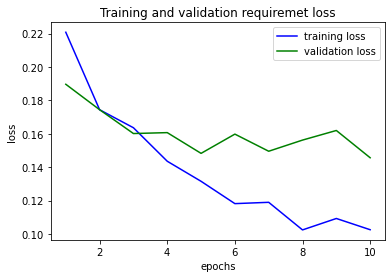

In [8]:
# train NN3

filepath = '/scratch/user/mahin/ANN/model/5-newdata/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history3 = model3.fit(X_train, y_train, 
                      epochs=10, batch_size=256, 
                      verbose=1, callbacks=[checkpoint],
                      validation_data=(X_val, y_val))

# Show loss

epochs = range(1,11)
plt.plot(epochs, history3.history['loss'], 'b', label = 'training loss')
plt.plot(epochs, history3.history['val_loss'], 'g', label = 'validation loss')
plt.title('Training and validation requiremet loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

In [11]:
# train again with all data and 20 epoch
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val))

history3 = model3.fit(X, y, epochs=5, batch_size=256)

model3.save('/scratch/user/mahin/ANN/model5.h5')

Epoch 1/5
17252/17252 [==============================] - 14s 812us/step - loss: 0.2171
Epoch 2/5
17252/17252 [==============================] - 13s 728us/step - loss: 0.1555
Epoch 3/5
17252/17252 [==============================] - 13s 727us/step - loss: 0.1375
Epoch 4/5
17252/17252 [==============================] - 13s 726us/step - loss: 0.1259
Epoch 5/5
17252/17252 [==============================] - 12s 724us/step - loss: 0.1151
